In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import scipy.stats as st

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [2]:
data = pd.read_csv("input/data-attendance-2.txt")

In [3]:
data

,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23
5,6,0,133,61,60
6,7,0,111,49,35
7,8,1,147,76,47
8,9,0,146,78,63
9,10,0,145,64,57


## モデル式

$$\lambda_i = \exp (b_1 + b_2 A_i + b_3 Score_i)$$
$$M_i \sim Poisson(\lambda_i)$$

In [4]:
def model(a, score, m):
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    b3 = pyro.sample("b3", dist.Normal(0, 10))
    
    lambda_ = torch.exp(b1 + b2 * a + b3 * score)
    with pyro.plate("data", len(a)):
        pyro.sample("obs", dist.Poisson(lambda_), obs=m)

In [5]:
a = torch.tensor(data.A.values).float()
score = torch.tensor(data.Score.values).float() / 200.
m = torch.tensor(data.M.values).float()

In [6]:
hmc_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
mcmc_posterior = MCMC(hmc_kernel, num_samples=1000, num_chains=4, warmup_steps=1000).run(a, score, m)

In [7]:
sites = ["b1", "b2", "b3"]
mcmc_samples = mcmc_posterior.marginal(sites).support(flatten=True)
mcmc_df = pd.DataFrame(EmpiricalMarginal(mcmc_posterior, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).cpu().numpy(), columns=sites)

In [8]:
df_stats = mcmc_df.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T
df_stats["mean"] = mcmc_df.mean(0)
df_stats

,0.025,0.25,0.5,0.75,0.975,mean
b1,3.380704,3.515479,3.577140,3.639869,3.750131,3.576195
b2,0.186269,0.237868,0.263966,0.290957,0.340937,0.264159
b3,0.001444,0.191158,0.291933,0.386195,0.585318,0.291656


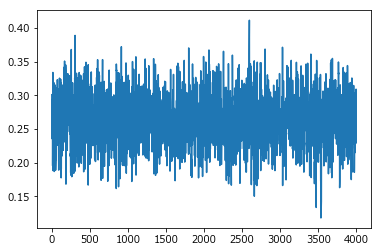

In [9]:
mcmc_df.b2.plot()

In [11]:
def predict_model(a, score):
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    b3 = pyro.sample("b3", dist.Normal(0, 10))
    
    lambda_ = torch.exp(b1 + b2 * a + b3 * score)
    pyro.sample("m", dist.Poisson(lambda_))

In [12]:
predictive_distribution = TracePredictive(predict_model, mcmc_posterior, num_samples=1000).run(a, score)

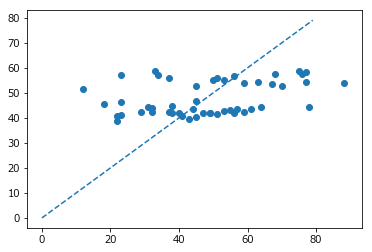

In [16]:
m_samples = EmpiricalMarginal(predictive_distribution, "m")._get_samples_and_weights()[0].numpy().mean(0)

plt.plot(torch.arange(0,80).numpy(), torch.arange(0, 80).numpy(), '--')
plt.scatter(data.M, m_samples)